<a href="https://colab.research.google.com/github/Ekaterina946/dls-gan/blob/master/Copy_of_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [3]:
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install Pillow

In [ ]:
import PIL

In [ ]:
!pip install imread

     |████████████████████████████████| 1.6MB 2.8MB/s 


In [ ]:
pip install Pillow imageio

In [2]:
import imageio
from PIL import Image

In [1]:
import numpy as np
import os
# import imread
import imageio
import pandas as pd

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
smile = attrs.loc[(attrs['Smiling'] >= 1) & (attrs['Sunglasses'] <= 0)]

In [ ]:
smile.head(15)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
5,0.850491,-1.48208,1.90852,-1.87365,-3.22993,-0.864006,0.31382,-0.35268,-1.55929,-1.91459,-0.183774,-0.611104,-1.12559,1.88155,-1.42656,-2.02517,-1.08598,1.32771,-1.49902,-1.0821,-1.51491,-0.619491,-0.724844,0.239398,-0.00587801,0.861121,0.281811,-0.896384,0.50386,-0.665195,-0.0108389,1.01641,-0.507268,-0.712192,-0.395029,-0.543325,1.09159,1.88456,0.355624,0.241287,-0.829593,-0.724306,1.19546,-1.8133,-0.788424,0.739353,-0.856222,-0.104318,-0.911016,-0.821423,-0.227976,-0.214095,-0.914161,0.484954,2.05128,1.16484,-0.0113163,-1.47652,-1.78473,1.32262,-0.465064,-3.41187,-0.935043,1.77547,-1.0635,1.35435,-0.960133,-5.35464,1.15002,-0.142195,-0.672725,0.886694,-0.154051
8,0.286489,-1.90351,0.697239,-1.85985,-1.44025,-1.55243,0.102555,-0.191471,-0.726333,-0.226157,-0.960942,0.883486,-1.54019,2.03712,-1.79367,-1.06284,-0.815287,1.04339,-1.03926,-0.336566,-0.955972,-0.3267,-0.602744,-0.0301018,0.0609864,-0.18539,-1.04398,0.110099,-1.125,0.888272,0.11737,-0.9451,-0.427191,-0.219541,-0.211102,0.169996,0.980864,0.141318,0.689054,0.76991,-0.903777,-1.11681,-0.215057,-0.0207795,-1.03589,0.153006,-0.219807,0.181432,-0.286476,-1.05326,-0.149979,-0.753525,-0.44484,3.29466,-0.313387,0.155056,-0.671935,-0.376232,-1.48105,0.285955,-0.662831,-2.5849,-0.398156,-1.41784,-0.483956,0.717483,-0.288405,-2.29545,0.937971,1.23307,-0.632812,0.00999485,-0.144265
9,0.663497,-1.03694,0.46161,-2.49853,-2.81593,-1.63779,-0.20148,-0.134941,-1.32816,-0.712721,-1.04643,0.751971,-1.07845,0.508052,-0.955831,-1.39705,-0.393789,1.27319,-0.921499,-1.19207,-0.650999,-0.0646937,-1.16104,0.474989,0.680129,-0.134076,-0.957666,0.815776,-0.771003,-0.712388,-0.310099,-0.598794,-0.413883,-0.998702,-0.145115,-0.972335,0.791311,1.37849,1.32976,-0.164918,-0.0251796,-0.119012,-0.277203,-0.776074,-0.735357,-0.533107,-0.027968,-0.00688656,-0.858842,-1.03422,0.0417565,-0.431964,-0.884496,2.59033,0.89871,0.472471,-0.892174,-0.419689,-1.5762,1.68762,-0.78384,-0.441403,-1.19935,1.43291,0.771419,1.59549,-0.697505,-2.51197,0.98124,0.424768,-0.518236,-0.306921,0.348492
11,0.891376,-0.438415,-0.0914528,-1.7389,-1.02499,-1.46406,-0.720319,-0.660456,0.422967,-0.994338,-0.861802,-1.47849,0.0448106,-1.83904,1.364,-1.05956,-0.708427,1.04279,-0.985953,-0.0153609,-0.870919,0.209452,-0.612433,0.00251882,-0.0262948,1.20671,-0.469633,-0.115299,1.50081,-1.17389,-0.150321,1.72087,-0.756571,-1.15229,-0.130448,0.306728,0.901029,0.281118,1.52427,-0.320513,-0.673076,-1.95822,-0.287539,0.606163,-1.21071,0.65036,-0.232447,0.209564,0.707926,-0.347586,-0.00799364,-0.490397,-0.611137,3.16645,-0.500568,-0.935811,-1.14465,-1.31429,-0.0549196,0.533673,-0.791892,1.87284,-0.610418,1.29485,-0.470484,0.806376,-1.02115,1.07103,0.00847368,0.441745,-0.575209,0.428245,0.0494204
26,1.89823,1.08339,-1.22851,-1.41631,-2.75757,-1.10117,-0.470595,-0.218677,-0.806491,-1.41484,-1.00858,0.202754,0.0703547,0.400184,-0.385587,-1.5906,-0.178473,1.51203,-1.65498,0.124311,-0.920825,-0.811478,-0.195442,-0.749001,-0.614256,-0.723917,0.0311348,1.52504,0.619817,-0.737565,-0.23283,0.677438,-0.714539,-0.932887,1.58934,0.882231,2.50064,0.36015,1.68482,-0.917577,0.0447821,-1.65507,0.8461

In [ ]:
a = [5, 8, 9, 11, 26, 34, 60, 83, 88, 96, 101, 106, 108, 132, 135]

In [ ]:
data_smile = data[a]

In [ ]:
sad = attrs.loc[(attrs['Smiling'] <=0) & (attrs['Sunglasses'] <= 0)]

In [ ]:
sad.head(15)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
6,0.944548,-1.37722,1.29906,-1.40534,-1.86233,-0.502664,-0.48629,0.0150016,-0.892478,-0.586615,-0.578652,0.00809665,-1.47886,2.28823,-0.795083,-1.65276,-0.999469,-1.251,1.1896,-0.516286,-0.684159,-0.343478,-1.22714,0.756459,-0.328009,1.69043,-0.400995,-1.12714,0.685496,-0.618742,0.104503,1.16725,-0.831819,-0.865513,0.376118,-0.924331,1.81563,0.38526,-0.154358,0.820813,0.104255,-1.51841,0.559508,-0.645737,0.0481367,0.623667,-0.388867,0.119704,-0.36893,-1.68699,0.178891,-0.234473,-0.961875,0.293788,0.123722,0.329416,-0.863599,-1.62817,-1.00675,-0.593151,-0.651478,-3.73208,-1.02099,0.155763,-0.0333257,-0.869705,-0.942216,-3.77615,-1.0283,0.0992853,-0.335493,0.185644,-0.671966
7,1.59467,-1.50443,0.441401,-1.77175,-2.44985,-1.10597,-0.0425912,-0.136437,-1.00851,0.653294,-1.05465,0.14009,-0.992839,1.28669,-1.64724,-1.54434,-1.06409,-0.939041,1.07017,0.393881,-0.226298,0.97752,0.467644,-0.0343907,-1.80258,0.581171,-0.397856,-0.353207,-0.401198,-0.767375,-0.139804,-0.527604,0.147988,-0.960355,0.956248,-1.40874,-0.238071,2.29736,0.0614189,1.07433,-0.460882,-1.98861,1.18745,-0.544106,-1.08539,0.494696,-0.055713,-0.140553,-0.288512,-0.715019,0.555763,-0.505857,-0.731868,4.77807,0.356774,0.0696783,-0.733874,-0.676234,-0.806292,-0.929818,-0.8004,-1.3747,-0.766161,-3.25803,0.128691,-1.57324,-1.10214,-1.12391,-1.39417,1.52065,-0.487475,0.601968,-0.617698
10,1.91097,-1.48919,0.620388,-1.1619,-1.14547,-1.54664,-1.55356,0.206915,-0.659479,-1.11711,-1.24559,0.342866,-0.807649,0.320039,-0.424018,-1.54103,2.22882,-1.2233,1.13436,0.857195,-1.11841,0.388749,-0.840141,0.862729,0.361503,0.242272,-0.0312012,-0.202028,1.94552,-0.335967,0.524441,1.04227,-0.622057,-0.322106,1.10647,-1.05321,0.740086,0.547203,1.17164,0.224645,0.158398,0.0157301,-0.945023,-0.596312,1.09415,-2.6917,0.899463,0.210731,0.404482,-0.602943,-0.647487,0.121021,-0.529726,1.50471,-0.865032,-0.777743,-1.26898,-0.27084,-0.404998,1.12604,-1.58629,1.19295,-0.912569,0.661369,2.81824,0.363108,-2.17611,-1.2993,-1.29147,1.88404,-1.40578,0.770559,-1.18558
13,1.23939,-1.32909,-0.188062,-1.38147,-2.02567,-0.881739,-0.94792,-0.18215,-0.773713,-0.247106,-1.18275,-0.245659,-0.569221,-0.986084,-0.794811,-0.0577555,1.30962,-0.54646,0.397718,-0.268929,0.148246,-0.105183,-0.943453,1.43703,0.108421,-0.424107,-0.64349,-0.25113,0.630584,-1.77244,0.475204,-0.503368,-0.202777,-1.05297,0.798877,-0.360938,-0.872162,0.683152,0.659126,0.18243,0.370685,0.407678,-0.832745,-0.578218,0.523623,-2.15

In [ ]:
b = [0, 6, 7, 10, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25]

In [ ]:
data_sad = data[b]

In [5]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

In [ ]:
dim_code = 100


Разбейте выборку картинок на train и val:

In [43]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [99]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    images = np.array(images, dtype='float32')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        inp = images[i]
        mean = np.array((0.5, 0.5, 0.5))
        std = np.array((0.5, 0.5, 0.5))
        inp = std * inp + mean
        try:
            plt.imshow(inp, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

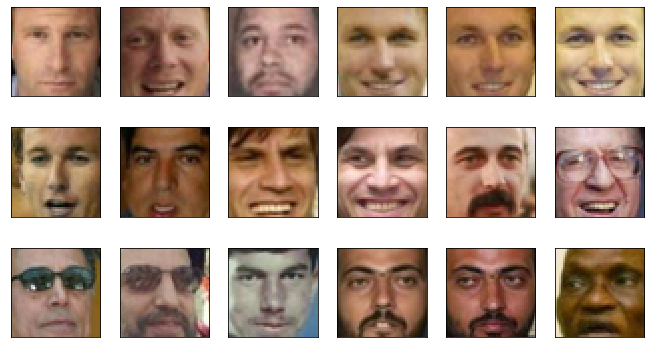

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

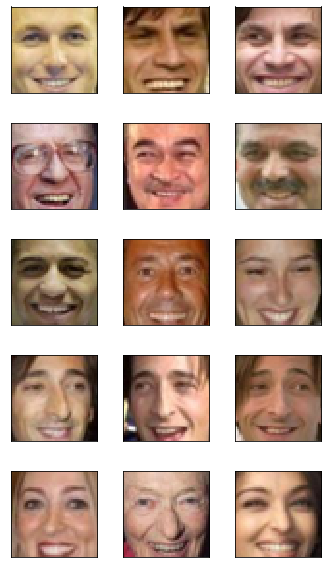

In [ ]:
plot_gallery(data_smile, 45, 45, 5, 3)

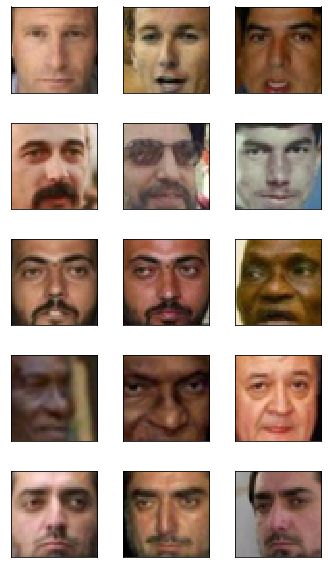

In [ ]:
plot_gallery(data_sad, 45, 45, 5, 3)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [8]:
def To_tens(dataset):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    new_set = []
    for i in range(len(dataset)):
        x = np.array(dataset[i].transpose((0, 1, 2)) / 255, dtype='float32')
        new_set.append(transform(x))
    return torch.stack(new_set).permute(0, 2, 3, 1)

In [44]:
X_train = To_tens(X_train)
X_val = To_tens(X_val)

In [ ]:
data_smile = To_tens(data_smile)
data_sad = To_tens(data_sad)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [10]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [11]:
# from copy import deepcopy

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = nn.Linear(6075, 1024)
        self.e2 = nn.Linear(1024, 1024)
        self.e3 = nn.Linear(1024, 256)
        
        #Latent View
        self.lv = nn.Linear(256, dim_code)

    def forward(self, x):
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        x = F.relu(self.e3(x))
        
        latent_code = torch.sigmoid(self.lv(x))
        return latent_code

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()


        self.d1 = nn.Linear(dim_code, 256)
        self.d2 = nn.Linear(256, 1024)
        self.d3 = nn.Linear(1024, 1024)
        
        self.output_layer = nn.Linear(1024, 6075)

    def forward(self,x):

        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = F.relu(self.d3(x))
        
        reconstruction = self.output_layer(x)
        
        return reconstruction


class Vanilla(nn.Module):

    def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

    def forward(self, x):
            # encode
            latent_code = self.enc(x)

            # decode
            predicted = self.dec(latent_code)
            return predicted, latent_code


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [13]:
criterion = nn.MSELoss()
encoder = Encoder()
decoder = Decoder()
autoencoder = Vanilla(encoder, decoder).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [14]:
epochs = 10

In [15]:
train_loader = DataLoader(X_train, batch_size=50, shuffle=True)
val_loader = DataLoader(X_val, batch_size=50, shuffle=True)

In [16]:
def train(train, val, epochs, autoencoder, loss_fn, optimizer):
    trainl = []
    vall = []
    for epoch in range(epochs):
        # X_val = next(iter(val)
        recon = []
        train_loss = 0.0
        val_loss = 0.0
        # print('* Epoch %d/%d' % (epoch+1, epochs))
        autoencoder.train()
        # encoder.train()
        # decoder.train()

        for X_batch in train:

            X_batch = X_batch.to(device)
            X_batch = X_batch.view(X_batch.size(0), 45*45*3)
            optimizer.zero_grad()
            # code = encoder(X_batch)
            # rec = decoder(code)
            rec, code = autoencoder(X_batch)

            loss = loss_fn(X_batch, rec)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        trainl.append(train_loss / len(train))


        # print('loss: %f' % train_loss)
        autoencoder.eval()
        # encoder.eval()
        # decoder.eval()
        for X_val in val:
            X_val = X_val.to(device)
            X_val = X_val.view(X_val.size(0), 45*45*3)
            with torch.no_grad():
                # clear_output(wait=True)
                # latent_code = encoder(X_val)
                # reconstruction = decoder(latent_code)
                reconstruction, latent_code =  autoencoder(X_val)
                # X_val = X_val.detach().to(device).numpy().reshape(X_val.size(0),45,45, 3)
                # reconstruction = reconstruction.detach().to(device).numpy().reshape(reconstruction.size(0), 45, 45, 3)
                # plot_gallery([X_val.astype(np.uint8), reconstruction.astype(np.uint8)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
                loss = loss_fn(X_val, reconstruction)
                reconstruction = reconstruction.view(X_val.size(0),45,45, 3)

            recon.append(reconstruction)
            val_loss += loss.item()
        vall.append(val_loss / len(val))
        clear_output(wait=True)


        for k in range(6):
          plot_gallery([np.array(X_val[k]), np.array(reconstruction[k].detach().to(device))], h = 45, w = 45, n_row=1, n_col=2)
          plt.show()

        plt.plot(range(len(trainl)), trainl, label ='train')
        plt.plot(range(len(vall)), vall, label ='val')
        plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, epochs, trainl[epoch], vall[epoch]))
        # plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, \
                                                                #  epochs, trainl[epoch], vall[epoch]))
        plt.legend()
        plt.show()


      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


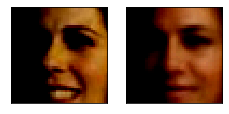

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


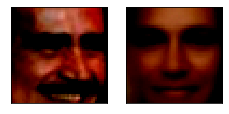

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


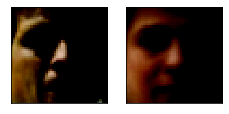

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


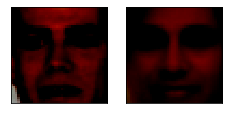

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


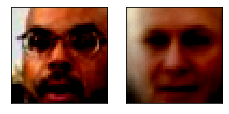

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


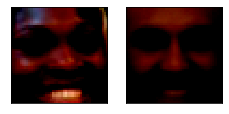

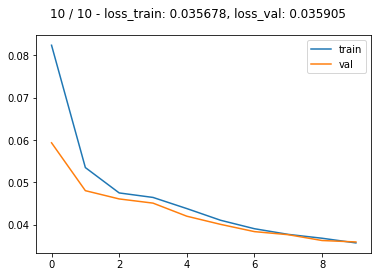

In [17]:
train(train_loader, val_loader, epochs, autoencoder, criterion, optimizer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


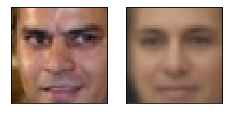

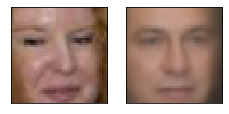

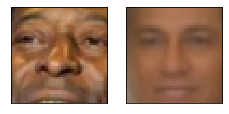

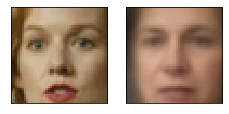

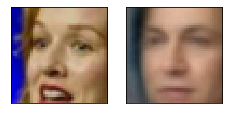

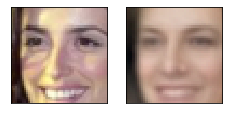

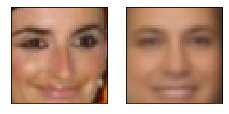

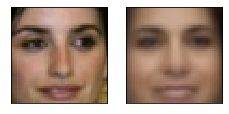

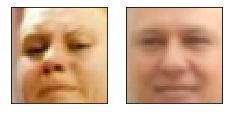

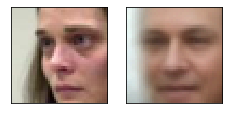

In [117]:
image = X_val[0:10]
image1 = image.reshape(image.size(0), 45*45*3)
image1 = image1.to(device)
output, latent = autoencoder(image1)
  # output = output.float()
output = output.view(-1, 45, 45, 3)
# plt.imshow(np.array(output[1].detach().to(device)))
for i in range(10):
    plot_gallery([np.array(image[i]), np.array(output[i].detach().to(device))], h = 45, w = 45, n_row=1, n_col=2)


Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

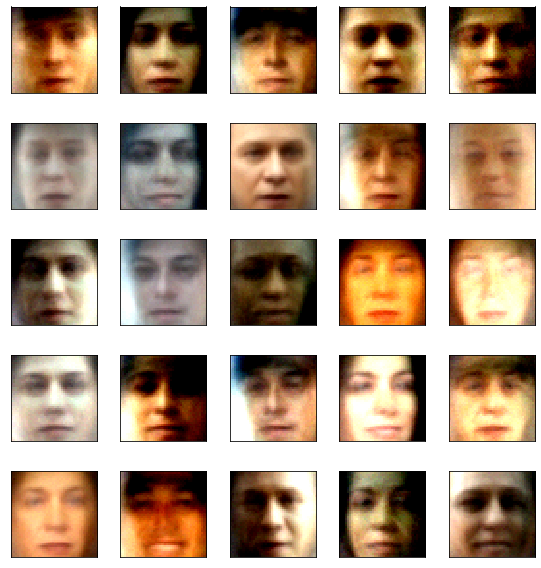

In [118]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 100)
output = decoder(torch.Tensor(z).to(device))
output = output.reshape(output.size(0),45,45, 3)
plot_gallery(np.array(output.detach().to(device)), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
data_smile = data_smile.to(device)
smile = data_smile.reshape(data_smile.size(0), 45*45*3)

data_sad = data_sad.to(device)
sad = data_sad.reshape(data_sad.size(0), 45*45*3)
latent_smile = encoder(smile)

latent_sad = encoder(sad)


In [ ]:
average_smile = (latent_smile[0] + latent_smile[1] + latent_smile[2] + latent_smile[3] + latent_smile[4] + latent_smile[5] + latent_smile[6] + latent_smile[7] + latent_smile[8])
average_smile = average_smile + latent_smile[9] + latent_smile[10] + latent_smile[11] + latent_smile[12] + latent_smile[13] + latent_smile[14]
average_smile = average_smile / 15


In [ ]:
average_sad = (latent_sad[0] + latent_sad[1] + latent_sad[2] + latent_sad[3] + latent_sad[4] + latent_sad[5] + latent_sad[6] + latent_sad[7] + latent_sad[8])
average_sad = average_sad + latent_sad[9] + latent_sad[10] + latent_sad[11] + latent_sad[12] + latent_sad[13] + latent_sad[14]
average_sad = average_sad / 15

In [ ]:
delta = average_smile - average_sad

In [ ]:
for i in range(15):
    latent_sad[i] = latent_sad[i] + delta

In [ ]:
res = decoder(latent_sad)

In [ ]:
res = res.reshape(res.size(0),45,45, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


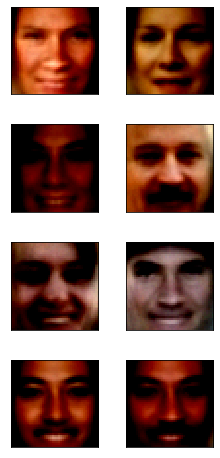

In [ ]:
plot_gallery(np.array(res.detach().to(device)), IMAGE_H, IMAGE_W, n_row=4, n_col=2)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

Был реализован vae и cvae на датасете мнист, а для 3го бонуса vae на датасете лиц

In [119]:
from torch.nn import functional as F

In [189]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.linear = nn.Linear(28*28, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.linear2 = nn.Linear(500, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.mu = nn.Linear(100, 30)
        # self.bn3 = nn.BatchNorm1d(100)
        self.var = nn.Linear(100, 30)
        # self.bn4 = nn.BatchNorm1d(100)

    def gaussian_sampler(self, mu, logsigma):
            if self.training:
                std = logsigma.exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                return eps.mul(std).add_(mu)
            else:
                return mu


    def forward(self, x):
        hidden = F.leaky_relu(self.bn1(self.linear(x)))
        hidden2 = F.leaky_relu(self.bn2(self.linear2(hidden)))
        mu = self.mu(hidden2)
        logsigma = self.var(hidden2)
        latent = self.gaussian_sampler(mu, logsigma)
        
        return mu, logsigma, latent

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.latent_to_hidden = nn.Linear(30, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.hidden_to_out = nn.Linear(100, 500)
        self.bn4 = nn.BatchNorm1d(500)
        self.hidden_to_out2 = nn.Linear(500, 28*28)


    def forward(self, z):

          # z = self.gaussian_sampler(mu, logsigma)

          x = F.leaky_relu(self.bn3(self.latent_to_hidden(z)))
          x = F.leaky_relu(self.bn4(self.hidden_to_out(x)))
          reconstruction = F.sigmoid(self.hidden_to_out2(x))
          
        
          return reconstruction


class VAE(nn.Module):

    def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec



    def forward(self, x):
            # encode
            mu, logsigma, latent = self.enc(x)
            # latent = self.gaussian_sampler(mu, logsigma)

            # decode
            predicted = self.dec(latent)
            return predicted, mu, logsigma



Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [188]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.mean(1 + 2*logsigma - mu**2 - torch.exp(2*logsigma))
    return loss

def log_likelihood(reconstruction, x):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return 0.5 *(KL_divergence(mu, logsigma) / (28*28)+log_likelihood(reconstruction, x))

И обучим модель:

In [190]:
criterion = loss_vae
encoder = encoder()
decoder = decoder()
vae = VAE(encoder, decoder).to(device)


optim = torch.optim.Adam(vae.parameters(), lr = 0.0001)

In [124]:
from torchvision import transforms
from torchvision import datasets


In [125]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [171]:
def plot_gallery2(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    # images = np.array(images, dtype='float32')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.Greys_r, vmin=0, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [127]:
def train_vae(train, val, epochs, autoencoder, loss_fn, optim):
    trainl = []
    vall = []
    for epoch in range(epochs):
        # X_val = next(iter(val)
        recon = []
        train_loss = 0.0
        val_loss = 0.0
        # print('* Epoch %d/%d' % (epoch+1, epochs))
        autoencoder.train()
        # encoder.train()
        # decoder.train()

        for X_batch, labels in train:

            X_batch = X_batch.to(device)
            X_batch = X_batch.view(X_batch.size(0), 28*28)
            optim.zero_grad()
            # code = encoder(X_batch)
            # rec = decoder(code)
            rec, mu, log = autoencoder(X_batch)


            loss = loss_fn(torch.clamp(X_batch, 0, 1), mu, log, rec)
            loss.backward()
            optim.step()

            train_loss += loss.item()
        trainl.append(train_loss / len(train))


        # print('loss: %f' % train_loss)
        autoencoder.eval()
        # encoder.eval()
        # decoder.eval()
        for X_val, labels in val:
            X_val = X_val.to(device)
            X_val = X_val.view(X_val.size(0), 28*28)
            with torch.no_grad():
                # clear_output(wait=True)
                # latent_code = encoder(X_val)
                # reconstruction = decoder(latent_code)
                reconstruction, muu, logsigma =  autoencoder(X_val)
                # X_val = X_val.detach().to(device).numpy().reshape(X_val.size(0),45,45, 3)
                # reconstruction = reconstruction.detach().to(device).numpy().reshape(reconstruction.size(0), 45, 45, 3)
                # plot_gallery([X_val.astype(np.uint8), reconstruction.astype(np.uint8)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
                loss = loss_fn(torch.clamp(X_val, 0, 1), muu, logsigma, reconstruction)
                reconstruction = reconstruction.view(reconstruction.size(0), 1, 28, 28)

            recon.append(reconstruction)
            val_loss += loss.item()
        vall.append(val_loss / len(val))
        clear_output(wait=True)


        for k in range(6):
          plot_gallery2([np.array(X_val[k]), np.array(reconstruction[k].detach().to(device))], h = 28, w = 28, n_row=1, n_col=2)
          plt.show()

        plt.plot(range(len(trainl)), trainl, label ='train')
        plt.plot(range(len(vall)), vall, label ='val')
        plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, epochs, trainl[epoch], vall[epoch]))
        # plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, \
                                                                #  epochs, trainl[epoch], vall[epoch]))
        plt.legend()
        plt.show()

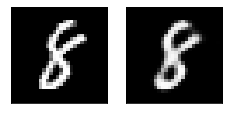

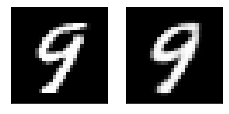

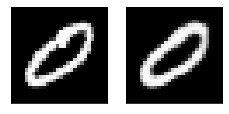

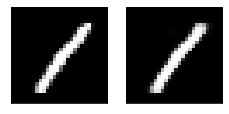

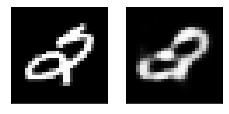

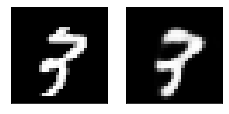

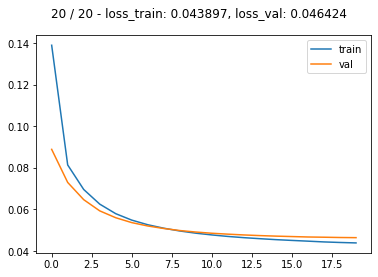

In [191]:
train_vae(train_loader, test_loader, 20, vae, criterion, optim)

In [130]:
import torchvision.datasets as dset

In [132]:
root = './data'

In [133]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


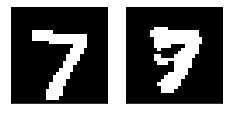

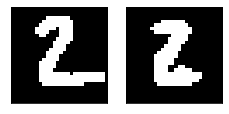

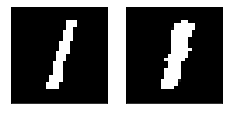

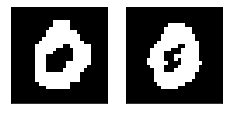

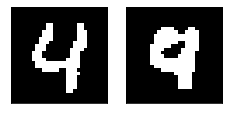

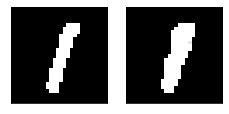

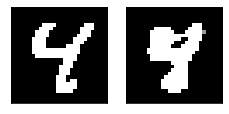

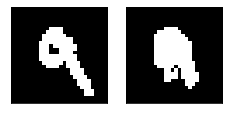

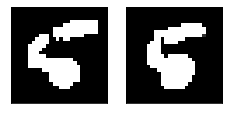

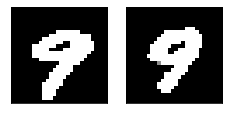

In [192]:
input = test_set.data.view(-1, 1, 28, 28).float()
image = input[0:10]
image1 = image.reshape(image.size(0), 28*28)
image1 = image1.to(device)
output, mu, log = vae(image1)
  # output = output.float()
output = output.view(-1, 1, 28, 28)
# plt.imshow(np.array(output[0].detach().to(device)))
for i in range(10):
    plot_gallery2([np.array(image[i]), np.array(output[i].detach().to(device))], h = 28, w = 28, n_row=1, n_col=2)


## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


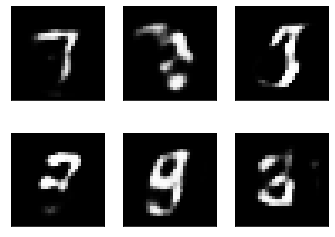

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# mu = np.array([np.random.normal(0,0.25, 100) for i in range(15)])
# sig = np.array([np.random.normal(0.75, 1, 100) for i in range(15)])
z = np.array([np.random.normal(0.5, 1, 30) for i in range(15)])
output = decoder(torch.Tensor(z).to(device))
plot_gallery2(output.data.cpu().numpy(), 28, 28, n_row=2, n_col=3)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
input = test_set.data.view(-1, 1, 28, 28).float()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE()

In [ ]:
mu, log, latent = encoder(input.to(device).reshape(-1, 28*28))

In [ ]:
latent_emb = tsne.fit_transform(latent.detach().to(device))

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


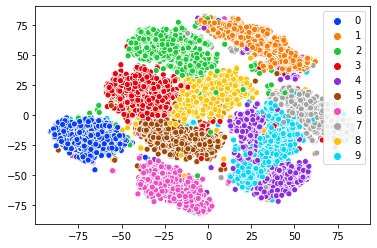

In [ ]:
sns.scatterplot(latent_emb[:,0], latent_emb[:,1], hue=test_set.targets, legend='full', palette='bright')

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [162]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [163]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
%matplotlib inline

In [164]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [165]:
batch_size = 32
latent_size = 100

In [166]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        # encode
        self.fc1  = nn.Linear(28*28 + 10, 400)
        self.bn1 = nn.BatchNorm1d(400)
        self.fc21 = nn.Linear(400, 30)
        self.fc22 = nn.Linear(400, 30)

        # decode
        self.fc3 = nn.Linear(40, 400)
        self.bn2 = nn.BatchNorm1d(400)
        self.fc4 = nn.Linear(400, 28*28)

    def gaussian_sampler1(self, mu, logsigma):
            if self.training:
                std = logsigma.exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                return eps.mul(std).add_(mu)
            else:
                return mu
    
    def encode(self, x, c): 
        inputs = torch.cat([x, c], 1)
        h1 = F.leaky_relu(self.bn1(self.fc1(inputs)))
        mu = self.fc21(h1)
        var = self.fc22(h1)
        lat = self.gaussian_sampler1(mu, var)
        return mu, var, lat

    def gaussian_sampler(self, mu, log_var):
            std = torch.exp(0.5*log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add(mu)

    def decode(self, z, c): # P(x|z, c)
        '''
        z: (bs, latent_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = F.leaky_relu(self.bn2(self.fc3(inputs)))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar, lat = self.encode(x.view(-1, 784), c)
        z = self.gaussian_sampler(mu, logvar)
        return self.decode(z, c), mu, logvar

In [167]:
def train_cvae(model, loss, optimizer, train_dataset, test_dataset, epochs = 10):
    model.train()
    trainl = []
    vall = []
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = Variable(data).to(device)
            # data = data.view(-1, 28*28)
            # data = torch.clamp(data, 0, 1)
            labels = one_hot(labels, 10).to(device)
            recon_batch, mu, logvar = model(data, labels)
            optimizer.zero_grad()
            loss = loss_function(data, mu, logvar, recon_batch)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        trainl.append(train_loss / len(train_loader))

        model.eval()
        for i, (data, labels) in enumerate(test_loader):
            X_val = Variable(data).to(device)
            # X_val = X_val.view(-1, 28*28)
            # X_val = torch.clamp(X_val, 0, 1)
            labels = one_hot(labels, 10).to(device)
            reconstruction, mu, logvar = model(X_val, labels)
            test_loss += loss_function(X_val, mu, logvar, reconstruction).item()

        vall.append(test_loss / len(test_loader))

        clear_output(wait=True)


        for k in range(6):
              plot_gallery2([np.array(X_val[k]), np.array(reconstruction[k].detach().to(device))], h = 28, w = 28, n_row=1, n_col=2)
              plt.show()

        plt.plot(range(len(trainl)), trainl, label ='train')
        plt.plot(range(len(vall)), vall, label ='val')
        plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, epochs, trainl[epoch], vall[epoch]))
            # plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, \
                                                                    #  epochs, trainl[epoch], vall[epoch]))
        plt.legend()
        plt.show()
    


In [168]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.mean(1 + 2*logsigma - mu**2 - torch.exp(2*logsigma))
    return loss

def log_likelihood(reconstruction, x):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy
    return loss(reconstruction, x.view(-1, 28*28))

def loss_cvae(x, mu, logsigma, reconstruction):
    return 0.5 *(KL_divergence(mu, logsigma) / (28*28)+log_likelihood(reconstruction, x))

In [181]:
model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = loss_cvae

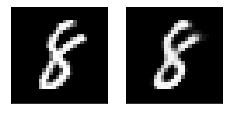

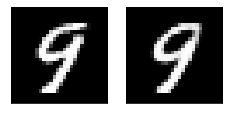

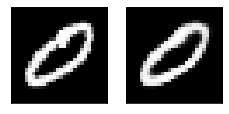

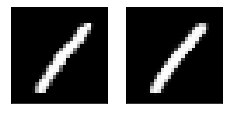

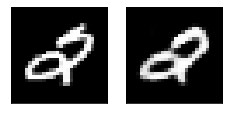

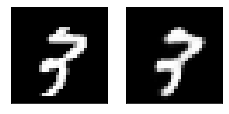

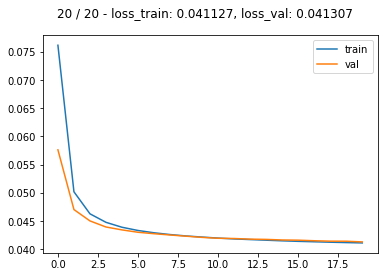

In [182]:
train_cvae(model, loss_function, optimizer, train_dataset, test_dataset, 20)

## Sampling


In [175]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

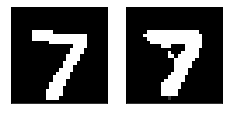

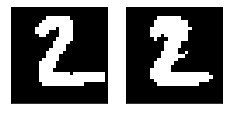

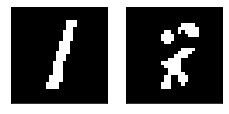

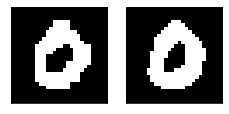

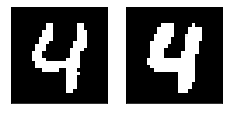

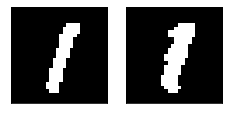

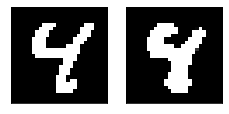

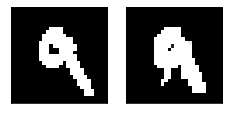

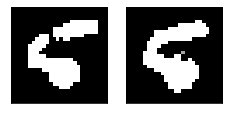

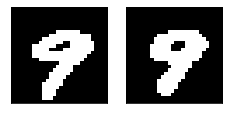

In [183]:
input = test_set.data.view(-1, 1, 28, 28).float()
# labels = test_set.targets
labels = one_hot(test_set.targets, 10).to(device)
# image = input[0:10]
# image1 = image.reshape(image.size(0), 28*28)
image1 = input.to(device)
output, mu, log = model(image1, labels)
  # output = output.float()
output = output.view(-1, 1, 28, 28)
# plt.imshow(np.array(output[0].detach().to(device)))
for i in range(10):
    plot_gallery2([np.array(input[i]), np.array(output[i].detach().to(device))], h = 28, w = 28, n_row=1, n_col=2)

Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
labels = torch.tensor([0, 0, 0, 0, 0, 0])

In [ ]:
c = one_hot(labels, 10)

In [ ]:
z = np.array([np.random.normal(0.5, 1, 30) for i in range(6)])

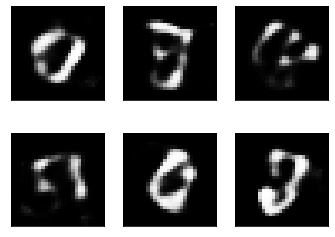

In [ ]:
output = model.decode(torch.Tensor(z).to(device), c.to(device))
plot_gallery2(output.data.cpu().numpy(), 28, 28, n_row=2, n_col=3)

In [ ]:
labels = torch.tensor([3, 3, 3, 3, 3, 3])
c = one_hot(labels, 10)

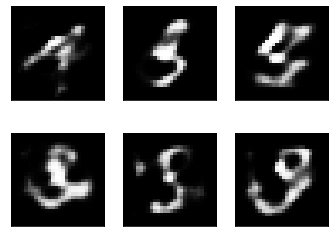

In [ ]:
output = model.decode(torch.Tensor(z).to(device), c.to(device))
plot_gallery2(output.data.cpu().numpy(), 28, 28, n_row=2, n_col=3)

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
def sampling(mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) 

In [ ]:
input = test_set.data.view(-1, 1, 28, 28).float()
targ = one_hot(test_set.targets, 10).to(device)
tsne = TSNE()
mu, log, lat = model.encode(input.to(device).reshape(-1, 28*28), targ)

In [ ]:
latent_emb = tsne.fit_transform(lat.detach().to(device))

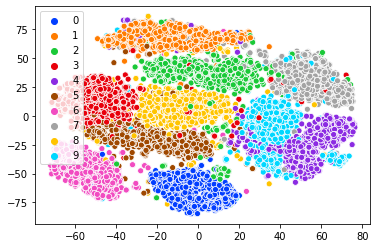

In [ ]:
sns.scatterplot(latent_emb[:,0], latent_emb[:,1], hue=test_set.targets, legend='full', palette='bright')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
second = X_train[100]

In [ ]:
first = X_train[238]

In [ ]:
second = torch.tensor(second)
first = torch.tensor(first)

In [ ]:
first = first.reshape(45*45*3)
second = second.reshape(45*45*3)
latent_first = encoder(first.to(device))
latent_second = encoder(second.to(device))

In [ ]:
def change(x, y, al):
    return (al * x + (1 - al) * y)

In [ ]:
alpha = 1
r = []
for i in range(10):
  alpha = alpha - 0.1
  res = decoder(change(latent_first, latent_second, alpha).to(device))
  res = res.reshape(45, 45, 3)
  res = np.array(res.detach().to(device))
  r.append(res)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

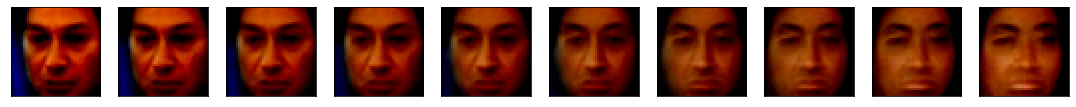

In [ ]:
plot_gallery(r, h = 45, w = 45, n_row=1, n_col=10)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
criterion = nn.MSELoss()
encoder = Encoder()
decoder = Decoder()
autoencoder = Vanilla(encoder, decoder).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
def noise(X_train):
    X_train = torch.clamp(X_train, 0, 1)
    X_noise = np.array(X_train) + 0.2 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
    return X_noise

In [ ]:
def train(train, val, epochs, autoencoder, loss_fn, optimizer):
    trainl = []
    vall = []
    for epoch in range(epochs):
        # X_val = next(iter(val)
        recon = []
        train_loss = 0.0
        val_loss = 0.0
        # print('* Epoch %d/%d' % (epoch+1, epochs))
        autoencoder.train()
        # encoder.train()
        # decoder.train()

        for X_batch in train:

            X_noisy = noise(X_batch)
            # X_noisy = X_noisy.astype(np.float32)
            X_noisy = torch.FloatTensor(X_noisy)
            X_batch = X_batch.to(device)
            X_noisy = X_noisy.to(device)
            X_noisy = X_noisy.view(X_noisy.size(0), 45*45*3)
            X_batch = X_batch.view(X_batch.size(0), 45*45*3)
            optimizer.zero_grad()
            # code = encoder(X_batch)
            # rec = decoder(code)
            rec, code = autoencoder(X_noisy)

            loss = loss_fn(torch.clamp(X_batch, 0 ,1), rec)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        trainl.append(train_loss / len(train))


        # print('loss: %f' % train_loss)
        autoencoder.eval()
        # encoder.eval()
        # decoder.eval()
        for X_val in val:
            X_noisy = noise(X_val)
            # X_noisy = X_noisy.astype(np.float32)
            X_noisy = torch.FloatTensor(X_noisy)

            X_noisy = X_noisy.to(device)
            X_val = X_val.to(device)
            X_val = X_val.view(X_val.size(0), 45*45*3)
            X_noisy = X_noisy.view(X_noisy.size(0), 45*45*3)
            with torch.no_grad():
                # clear_output(wait=True)
                # latent_code = encoder(X_val)
                # reconstruction = decoder(latent_code)
                reconstruction, latent_code =  autoencoder(X_noisy)
                # X_val = X_val.detach().to(device).numpy().reshape(X_val.size(0),45,45, 3)
                # reconstruction = reconstruction.detach().to(device).numpy().reshape(reconstruction.size(0), 45, 45, 3)
                # plot_gallery([X_val.astype(np.uint8), reconstruction.astype(np.uint8)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
                loss = loss_fn(torch.clamp(X_val, 0, 1), reconstruction)
                reconstruction = reconstruction.view(X_val.size(0),45,45, 3)

            recon.append(reconstruction)
            val_loss += loss.item()
        vall.append(val_loss / len(val))
        clear_output(wait=True)


        for k in range(6):
          plot_gallery([np.array(X_noisy[k]), np.array(reconstruction[k].detach().to(device))], h = 45, w = 45, n_row=1, n_col=2)
          plt.show()

        plt.plot(range(len(trainl)), trainl, label ='train')
        plt.plot(range(len(vall)), vall, label ='val')
        plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, epochs, trainl[epoch], vall[epoch]))
        # plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, \
                                                                #  epochs, trainl[epoch], vall[epoch]))
        plt.legend()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


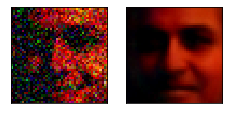

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


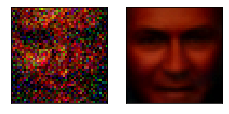

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


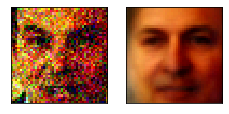

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


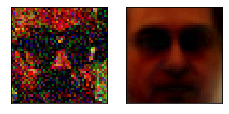

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


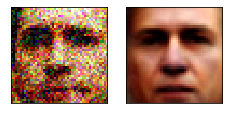

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


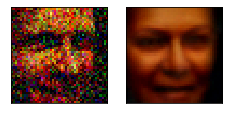

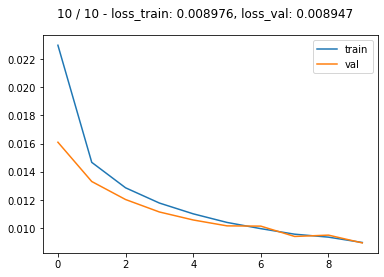

In [ ]:
train(train_loader, val_loader, epochs, autoencoder, criterion, optimizer)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
import random

In [ ]:
criterion = nn.MSELoss()
encoder = Encoder()
decoder = Decoder()
autoencoder = Vanilla(encoder, decoder).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
def occlusion(X):
    for  i in range (len(X)):
        a = random.randint(5, 30)
        w = random.randint(10, 12)
        b = random.randint(5, 30)
        h = random.randint(10, 12)
        X[i][a:a+w,b:b+h]=1.0 
    return(X)


In [ ]:
def train(train, val, epochs, autoencoder, loss_fn, optimizer):
    trainl = []
    vall = []
    for epoch in range(epochs):
        # X_val = next(iter(val)
        recon = []
        train_loss = 0.0
        val_loss = 0.0
        # print('* Epoch %d/%d' % (epoch+1, epochs))
        autoencoder.train()
        # encoder.train()
        # decoder.train()

        for X_batch in train:

            X_noisy = occlusion(torch.clamp(X_batch, 0, 1))
            # X_noisy = X_noisy.astype(np.float32)
            # X_noisy = torch.FloatTensor(X_noisy)
            X_batch = X_batch.to(device)
            X_noisy = X_noisy.to(device)
            X_noisy = X_noisy.view(X_noisy.size(0), 45*45*3)
            X_batch = X_batch.view(X_batch.size(0), 45*45*3)
            optimizer.zero_grad()
            # code = encoder(X_batch)
            # rec = decoder(code)
            rec, code = autoencoder(X_noisy)

            loss = loss_fn(torch.clamp(X_batch, 0 ,1), rec)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        trainl.append(train_loss / len(train))


        # print('loss: %f' % train_loss)
        autoencoder.eval()
        # encoder.eval()
        # decoder.eval()
        for X_val in val:
            X_noisy = occlusion(torch.clamp(X_val, 0, 1))
            # X_noisy = X_noisy.astype(np.float32)
            # X_noisy = torch.FloatTensor(X_noisy)

            X_noisy = X_noisy.to(device)
            X_val = X_val.to(device)
            X_val = X_val.view(X_val.size(0), 45*45*3)
            X_noisy = X_noisy.view(X_noisy.size(0), 45*45*3)
            with torch.no_grad():
                # clear_output(wait=True)
                # latent_code = encoder(X_val)
                # reconstruction = decoder(latent_code)
                reconstruction, latent_code =  autoencoder(X_noisy)
                # X_val = X_val.detach().to(device).numpy().reshape(X_val.size(0),45,45, 3)
                # reconstruction = reconstruction.detach().to(device).numpy().reshape(reconstruction.size(0), 45, 45, 3)
                # plot_gallery([X_val.astype(np.uint8), reconstruction.astype(np.uint8)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
                loss = loss_fn(torch.clamp(X_val, 0, 1), reconstruction)
                reconstruction = reconstruction.view(X_val.size(0),45,45, 3)

            recon.append(reconstruction)
            val_loss += loss.item()
        vall.append(val_loss / len(val))
        clear_output(wait=True)


        for k in range(6):
          plot_gallery([np.array(X_noisy[k]), np.array(reconstruction[k].detach().to(device))], h = 45, w = 45, n_row=1, n_col=2)
          plt.show()

        plt.plot(range(len(trainl)), trainl, label ='train')
        plt.plot(range(len(vall)), vall, label ='val')
        plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, epochs, trainl[epoch], vall[epoch]))
        # plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, \
                                                                #  epochs, trainl[epoch], vall[epoch]))
        plt.legend()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


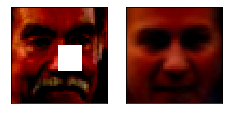

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


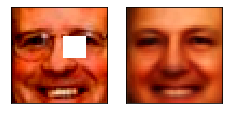

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


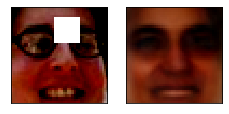

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


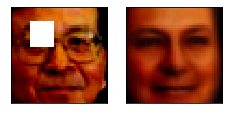

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


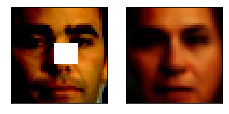

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


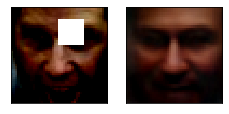

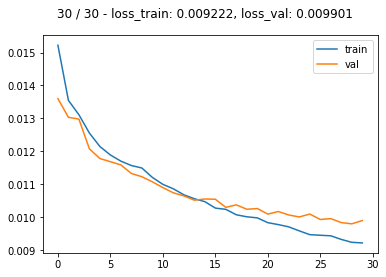

In [ ]:
train(train_loader, val_loader, 30, autoencoder, criterion, optimizer)

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.linear = nn.Linear(45*45*3, 45*45*3)
        # self.bn1 = nn.BatchNorm1d(28*28)
        self.linear2 = nn.Linear(45*45*3, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.mu = nn.Linear(1024, 100)
        # self.bn3 = nn.BatchNorm1d(100)
        self.var = nn.Linear(1024, 100)
        # self.bn4 = nn.BatchNorm1d(100)

    def gaussian_sampler(self, mu, logsigma):
            if self.training:
                std = logsigma.exp()
                eps = Variable(std.data.new(std.size()).normal_())
                return eps.mul(std).add_(mu)
            else:
                return mu


    def forward(self, x):
        hidden = F.relu(self.linear(x))
        hidden2 = F.relu(self.linear2(hidden))
        mu = self.mu(hidden2)
        logsigma = self.var(hidden2)
        latent = self.gaussian_sampler(mu, logsigma)
        
        return mu, logsigma, latent

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.latent_to_hidden = nn.Linear(100, 1024)
        # self.bn3 = nn.BatchNorm1d(1024)
        self.hidden_to_out = nn.Linear(1024, 45*45*3)
        # self.bn4 = nn.BatchNorm1d(28*28)
        self.hidden_to_out2 = nn.Linear(45*45*3, 45*45*3)


    # def gaussian_sampler(self, mu, logsigma):
    #         if self.training:
    #             std = logsigma.exp_()
    #             eps = Variable(std.data.new(std.size()).normal_())
    #             return eps.mul(std).add_(mu)
    #         else:
    #             return mu



    def forward(self, z):

          # z = self.gaussian_sampler(mu, logsigma)

          x = F.relu(self.latent_to_hidden(z))
          x = F.relu(self.hidden_to_out(x))
          reconstruction = F.sigmoid(self.hidden_to_out2(x))
          
        
          return reconstruction


class VAE(nn.Module):

    def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec



    def forward(self, x):
            # encode
            mu, logsigma, latent = self.enc(x)
            # latent = self.gaussian_sampler(mu, logsigma)

            # decode
            predicted = self.dec(latent)
            return predicted, mu, logsigma


In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.mean(1 + 2*logsigma - mu**2 - torch.exp(2*logsigma))
    return loss

def log_likelihood(reconstruction, x):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return 0.5 *(KL_divergence(mu, logsigma) / (45*45)+log_likelihood(reconstruction, x))

In [ ]:
criterion = loss_vae
encoder = encoder()
decoder = decoder()
vae = VAE(encoder, decoder).to(device)


optim = torch.optim.Adam(vae.parameters(), lr = 0.0001)

In [ ]:
def train_vae(train, val, epochs, model, loss_fn, optim):
    trainl = []
    vall = []
    for epoch in range(epochs):
        # X_val = next(iter(val)
        recon = []
        train_loss = 0.0
        val_loss = 0.0
        # print('* Epoch %d/%d' % (epoch+1, epochs))
        model.train()
        # encoder.train()
        # decoder.train()

        for X_batch in train:

            X_batch = X_batch.to(device)
            X_batch = X_batch.view(X_batch.size(0), 45*45*3)
            optim.zero_grad()
            # code = encoder(X_batch)
            # rec = decoder(code)
            rec, mu, log = model(X_batch)


            loss = loss_fn(torch.clamp(X_batch, 0, 1), mu, log, rec)
            loss.backward()
            optim.step()

            train_loss += loss.item()
        trainl.append(train_loss / len(train))


        # print('loss: %f' % train_loss)
        model.eval()
        # encoder.eval()
        # decoder.eval()
        for X_val in val:
            X_val = X_val.to(device)
            X_val = X_val.view(X_val.size(0), 45*45*3)
            with torch.no_grad():
                # clear_output(wait=True)
                # latent_code = encoder(X_val)
                # reconstruction = decoder(latent_code)
                reconstruction, muu, logsigma =  model(X_val)
                # X_val = X_val.detach().to(device).numpy().reshape(X_val.size(0),45,45, 3)
                # reconstruction = reconstruction.detach().to(device).numpy().reshape(reconstruction.size(0), 45, 45, 3)
                # plot_gallery([X_val.astype(np.uint8), reconstruction.astype(np.uint8)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
                loss = loss_fn(torch.clamp(X_val, 0, 1), muu, logsigma, reconstruction)
                reconstruction = reconstruction.view(reconstruction.size(0), 45, 45, 3)

            recon.append(reconstruction)
            val_loss += loss.item()
        vall.append(val_loss / len(val))
        clear_output(wait=True)


        for k in range(6):
          plot_gallery([np.array(X_val[k]), np.array(reconstruction[k].detach().to(device))], h = 45, w = 45, n_row=1, n_col=2)
          plt.show()

        plt.plot(range(len(trainl)), trainl, label ='train')
        plt.plot(range(len(vall)), vall, label ='val')
        plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, epochs, trainl[epoch], vall[epoch]))
        # plt.suptitle('%d / %d - loss_train: %f, loss_val: %f' % (epoch+1, \
                                                                #  epochs, trainl[epoch], vall[epoch]))
        plt.legend()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


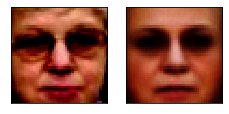

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


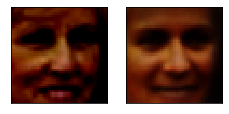

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


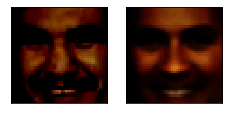

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


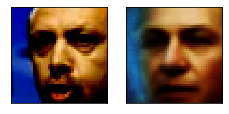

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


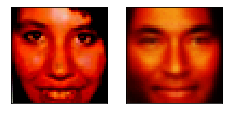

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


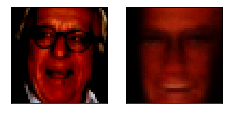

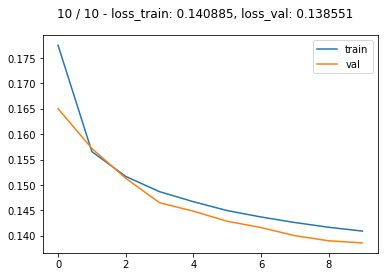

In [ ]:
train_vae(train_loader, val_loader, 10, vae, criterion, optim)

In [ ]:
mu, log, codes = encoder(X_train.reshape(X_train.size(0), 45*45*3).to(device))

In [ ]:
codes.size()

torch.Size([10000, 100])

In [ ]:
!pip install scikit-learn==0.20

     |████████████████████████████████| 5.3MB 2.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# обучаем LSHForest
import sklearn.neighbors
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach())

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  mu, log, code = encoder(image.reshape(45*45*3).to(device))
  code = code.reshape(1, -1)

    
  (distances,),(idx,) = lshf.kneighbors(code.detach(), n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image, n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([0,1,2]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([0, 1, 2,]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
image = X_val[30]

In [ ]:
image1 = image.reshape(45*45*3)

In [ ]:
image1.size()

torch.Size([6075])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

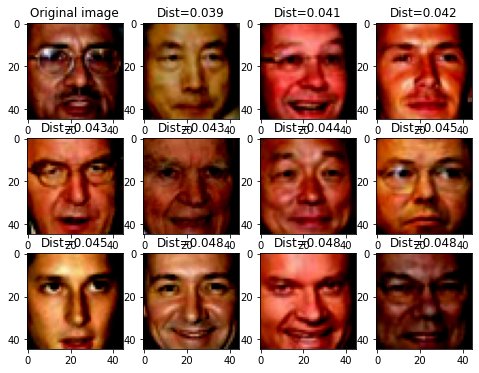

In [ ]:
show_similar(image)

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!